In [1]:
import numpy as np
import pandas as pd
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import IPython.display as ipd
from tqdm import tqdm

In [2]:
from hnr import *
from jitters import *
from shimmers import *
from sound import Waveform

In [3]:
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

2023-11-29 17:21:41.396183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 17:21:41.525605: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 17:21:42.018532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-29 17:21:42.018618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [4]:
data_path = "/home/bmis/Documents/AI-Workspace/ALS/bmis_data/All"

control_path = 'Control'
als_with_dysarthria_path = 'ALSwDysarthria'
als_without_dysarthria_path = 'ALSwoDysarthria'

control_dir = os.path.join(data_path, control_path)
control = os.listdir(control_dir)[0]

als_with_dir = os.path.join(data_path, als_with_dysarthria_path)
als_with_dys = os.listdir(als_with_dir)[1]

als_without_dir = os.path.join(data_path, als_without_dysarthria_path)
als_without_dys = os.listdir(als_without_dir)[1]

In [5]:
def extract_td_feature(audio_path):
    td_features = []
    _, sample_rate = librosa.load(audio_path)
    #print(audio_path)
    sound = Waveform(path=audio_path, sample_rate=sample_rate)

    td_features.append(sound.jitters()['localabsoluteJitter'])
    td_features.append(sound.jitters()['localJitter'])
    td_features.append(sound.jitters()['rapJitter'])
    td_features.append(sound.jitters()['ppq5Jitter'])

    td_features.append(sound.shimmers()['localShimmer'])
    td_features.append(sound.shimmers()['localdbShimmer'])
    td_features.append(sound.shimmers()['apq3Shimmer'])
    td_features.append(sound.shimmers()['apq5Shimmer'])
    td_features.append(sound.shimmers()['apq11Shimmer'])

    _ =(sound.hnr())
    hnr = sound.hnr()
    td_features.append(hnr)

    return np.array(td_features)

In [6]:
def get_all_td_features(data_path, label):
    data = []
    labels = []

    for file in tqdm(os.listdir(data_path)):
        #print(f'loading file: {file}')
        try:
            feature = extract_td_feature(os.path.join(data_path, file))
            data.append(feature)
            labels.append(label)
        except:
            print("Error encountered while parsing file: ", file)
            continue
    return data, labels

## 2 CLASS CLASSIFICATION USING LSTM

In [7]:
control_data, control_labels = get_all_td_features(control_dir, 0)
als_with_data, als_with_labels = get_all_td_features(als_with_dir, 1)
als_without_data, als_without_labels = get_all_td_features(als_without_dir, 1)

  0%|          | 0/199 [00:00<?, ?it/s]/home/bmis/Documents/AI-Workspace/ALS/bmis_data/code/hnr.py:81: RuntimeWarning: invalid value encountered in divide
  r_x = ffts_outputs[0] / ffts_outputs[1]
 12%|█▏        | 24/199 [00:13<01:28,  1.99it/s]/home/bmis/Documents/AI-Workspace/ALS/bmis_data/code/hnr.py:81: RuntimeWarning: divide by zero encountered in divide
  r_x = ffts_outputs[0] / ffts_outputs[1]
/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
 83%|████████▎ | 166/199 [01:32<00:22,  1.47it/s]/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bmis/ana

In [8]:
X = np.concatenate([control_data, als_with_data, als_without_data], axis=0)
y = np.concatenate([control_labels, als_with_labels, als_without_labels], axis=0)
X = np.array(X)

In [9]:
# Data Cleaning

X[X == None] = np.nan
X = np.nan_to_num(X, nan=0.0)
df = pd.DataFrame(X)
df.fillna(0.0, inplace=True)
X = df.to_numpy()

X = X.reshape(-1,10,1)

X, y = shuffle(X, y, random_state=0)

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(10,1)))  # 64 units in LSTM layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron for binary classification
# Print model summary
model.summary()

2023-11-29 17:30:18.557206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-29 17:30:18.593377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-29 17:30:18.593398: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-29 17:30:18.593806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

---------------------------------------------------
Epoch 1/100
18/19 [===========================>..] - ETA: 0s - loss: 0.6575 - accuracy: 0.6337
Epoch 1: loss improved from inf to 0.65342, saving model to lstm_two_class_model.h5
19/19 [==============================] - 2s 12ms/step - loss: 0.6534 - accuracy: 0.6377
Epoch 2/100
18/19 [===========================>..] - ETA: 0s - loss: 0.6166 - accuracy: 0.6910
Epoch 2: loss improved from 0.65342 to 0.61533, saving model to lstm_two_class_model.h5
19/19 [==============================] - 0s 11ms/step - loss: 0.6153 - accuracy: 0.6945
Epoch 3/100
17/19 [=========================>....] - ETA: 0s - loss: 0.6068 - accuracy: 0.7004
Epoch 3: loss improved from 0.61533 to 0.60998, saving model to lstm_two_class_model.h5
19/19 [==============================] - 0s 17ms/step - loss: 0.6100 - accuracy: 0.6962
Epoch 4/100
17/19 [=========================>....] - ETA: 0s - loss: 0.6086 - accuracy: 0.6857
Epoch 4: loss improved from 0.60998 to 0.604

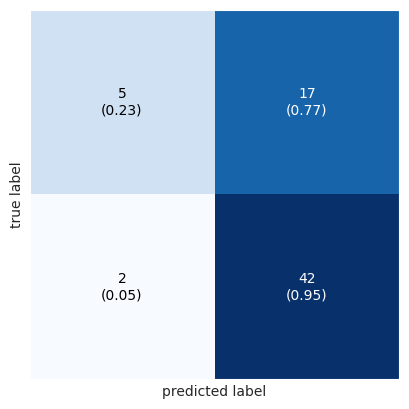

In [11]:
num_folds = 10
fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=False)
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
loss_per_fold = []

# Model Hyperparameters Turning
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1,
                                                 restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('lstm_two_class_model.h5', monitor='loss', verbose=1,
                                                      save_best_only=True)

for train, test in kfold.split(X, y):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('---------------------------------------------------')

    history = model.fit(X[train], y[train], epochs=100, verbose=1,
                        callbacks=[earlystopping, model_checkpoint])

    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    ###
    y_pred = model.predict(X[test])
    y_pred = np.round(y_pred).astype(int)
    
    precision = precision_score(y[test], y_pred)
    recall = recall_score(y[test], y_pred)
    f1 = f1_score(y[test], y_pred)

    

# Plot the confusion matrix

    #print('***************************************************')
    #print(f'Precision: {precision} -> Recall: {recall} -> F1: {f1}')
    #print('***************************************************')
    ##
    accuracy_per_fold.append(scores[1] * 100)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
    loss_per_fold.append(scores[0])

    if fold_no == 9:

        class_names = ['Control', 'ALS']
        confusion = confusion_matrix(y[test], y_pred)
        plot_confusion_matrix(conf_mat=confusion, class_names=class_names, show_normed=True, hide_ticks=True, cmap=plt.cm.Blues)
    
    
    fold_no += 1

In [12]:
print("Average Score per fold ")

for i in range(0, len(accuracy_per_fold)):
    print('-----------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
    print(f'> Fold {i+1} - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]} - F1: {f1_per_fold[i]}')
print('-----------------------------------------------')
print('Average Metrics for all folds: ')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Precision: {np.mean(precision_per_fold)} (+- {np.std(precision_per_fold)})')
print(f'> Recall: {np.mean(recall_per_fold)} (+- {np.std(recall_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('-----------------------------------------------')

Average Score per fold 
-----------------------------------------------
> Fold 1 - Loss: 0.5848872661590576 - Accuracy: 73.13432693481445%
> Fold 1 - Precision: 0.7313432835820896 - Recall: 1.0 - F1: 0.8448275862068965
-----------------------------------------------
> Fold 2 - Loss: 0.5765640139579773 - Accuracy: 65.67164063453674%
> Fold 2 - Precision: 0.6567164179104478 - Recall: 1.0 - F1: 0.7927927927927928
-----------------------------------------------
> Fold 3 - Loss: 0.5486482977867126 - Accuracy: 77.61194109916687%
> Fold 3 - Precision: 0.7761194029850746 - Recall: 1.0 - F1: 0.8739495798319328
-----------------------------------------------
> Fold 4 - Loss: 0.5812394022941589 - Accuracy: 67.16417670249939%
> Fold 4 - Precision: 0.7049180327868853 - Recall: 0.9148936170212766 - F1: 0.7962962962962963
-----------------------------------------------
> Fold 5 - Loss: 0.5725217461585999 - Accuracy: 71.6417908668518%
> Fold 5 - Precision: 0.7142857142857143 - Recall: 0.97826086956521

## 3 CLASS CLASSIFICATION USING LSTM

In [13]:
control_data, control_labels = get_all_td_features(control_dir, 0)
als_with_data, als_with_labels = get_all_td_features(als_with_dir, 1)
als_without_data, als_without_labels = get_all_td_features(als_without_dir, 2)


X = np.concatenate([control_data, als_with_data, als_without_data], axis=0)
y = np.concatenate([control_labels, als_with_labels, als_without_labels], axis=0)
X = np.array(X)


# Data Cleaning

X[X == None] = np.nan
X = np.nan_to_num(X, nan=0.0)
df = pd.DataFrame(X)
df.fillna(0.0, inplace=True)
X = df.to_numpy()
X = X.reshape(-1,10,1)

X, y = shuffle(X, y, random_state=0)

  0%|          | 0/199 [00:00<?, ?it/s]/home/bmis/Documents/AI-Workspace/ALS/bmis_data/code/hnr.py:81: RuntimeWarning: invalid value encountered in divide
  r_x = ffts_outputs[0] / ffts_outputs[1]
 12%|█▏        | 24/199 [00:12<01:27,  2.00it/s]/home/bmis/Documents/AI-Workspace/ALS/bmis_data/code/hnr.py:81: RuntimeWarning: divide by zero encountered in divide
  r_x = ffts_outputs[0] / ffts_outputs[1]
/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
 60%|█████▉    | 119/199 [01:05<01:00,  1.32it/s]/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bmis/ana

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, input_shape=(10, 1)))  # 64 units in LSTM layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Output layer with 1 neuron for binary classification

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [15]:
num_folds = 10
fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=False)
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
loss_per_fold = []

# Model Hyperparameters Turning
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1,
                                                 restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('lstm_three_class_model.h5', monitor='loss', verbose=1,
                                                      save_best_only=True)

for train, test in kfold.split(X, y):
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('---------------------------------------------------')

    history = model.fit(X[train], y[train], epochs=100, verbose=1,
                        callbacks=[earlystopping, model_checkpoint])

    scores = model.evaluate(X[test], y[test], verbose=0)


    y_pred = model.predict(X[test])
    y_pred  = np.argmax(y_pred, axis=-1)
    precision = precision_score(y[test], y_pred, average='weighted')
    recall = recall_score(y[test], y_pred, average='weighted')
    f1 = f1_score(y[test], y_pred, average='weighted')
    
    
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
    loss_per_fold.append(scores[0])
    """"
    if fold_no == 9:

        class_names = ['Control', 'ALS_with_dysarthria', 'ALS_without_dysarthria']
        confusion = confusion_matrix(y[test], y_pred)
        plot_confusion_matrix(conf_mat=confusion, figsize=(12,8), class_names=class_names, show_normed=True, hide_ticks=True, cmap=plt.cm.Blues)
    """
    fold_no += 1

---------------------------------------------------
Epoch 1/100
12/19 [=================>............] - ETA: 0s - loss: 1.1091 - accuracy: 0.3802 
Epoch 1: loss improved from inf to 1.09700, saving model to lstm_three_class_model.h5
19/19 [==============================] - 1s 6ms/step - loss: 1.0970 - accuracy: 0.4007
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0960 - accuracy: 0.3942
Epoch 2: loss improved from 1.09700 to 1.09426, saving model to lstm_three_class_model.h5
19/19 [==============================] - 0s 5ms/step - loss: 1.0943 - accuracy: 0.4007
Epoch 3/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0975 - accuracy: 0.3798
Epoch 3: loss improved from 1.09426 to 1.09061, saving model to lstm_three_class_model.h5
19/19 [==============================] - 0s 5ms/step - loss: 1.0906 - accuracy: 0.3940
Epoch 4/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0958 - accuracy: 0.4135
Epoch 4: loss improved from 1.09061 to 1

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/19 [=================>............] - ETA: 0s - loss: 1.0739 - accuracy: 0.4219 
Epoch 1: loss did not improve from 1.03830
19/19 [==============================] - 1s 5ms/step - loss: 1.0648 - accuracy: 0.4374
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0674 - accuracy: 0.4255
Epoch 2: loss did not improve from 1.03830
19/19 [==============================] - 0s 5ms/step - loss: 1.0531 - accuracy: 0.4457
Epoch 3/100
12/19 [=================>............] - ETA: 0s - loss: 1.0498 - accuracy: 0.4505
Epoch 3: loss did not improve from 1.03830
19/19 [==============================] - 0s 5ms/step - loss: 1.0482 - accuracy: 0.4524
Epoch 4/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0612 - accuracy: 0.4303
Epoch 4: loss did not improve from 1.03830
19/19 [==============================] - 0s 4ms/step - loss: 1.0559 - accuracy: 0.4257
Epoch 5/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0325 - accuracy: 0.4760
Epoch 5: loss di

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/19 [=================>............] - ETA: 0s - loss: 1.0677 - accuracy: 0.4453 
Epoch 1: loss did not improve from 1.03830
19/19 [==============================] - 2s 5ms/step - loss: 1.0588 - accuracy: 0.4491
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0549 - accuracy: 0.4351
Epoch 2: loss did not improve from 1.03830
19/19 [==============================] - 0s 5ms/step - loss: 1.0641 - accuracy: 0.4190
Epoch 3/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0584 - accuracy: 0.4399
Epoch 3: loss did not improve from 1.03830
19/19 [==============================] - 0s 5ms/step - loss: 1.0574 - accuracy: 0.4608
Epoch 4/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0641 - accuracy: 0.4375
Epoch 4: loss did not improve from 1.03830
19/19 [==============================] - 0s 5ms/step - loss: 1.0594 - accuracy: 0.4424
Epoch 5/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0653 - accuracy: 0.4399
Epoch 5: loss di

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/19 [=================>............] - ETA: 0s - loss: 1.0563 - accuracy: 0.4609 
Epoch 1: loss did not improve from 1.03830
19/19 [==============================] - 1s 5ms/step - loss: 1.0575 - accuracy: 0.4591
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0571 - accuracy: 0.4447
Epoch 2: loss did not improve from 1.03830
19/19 [==============================] - 0s 5ms/step - loss: 1.0505 - accuracy: 0.4407
Epoch 3/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0364 - accuracy: 0.4351
Epoch 3: loss did not improve from 1.03830
19/19 [==============================] - 0s 4ms/step - loss: 1.0424 - accuracy: 0.4374
Epoch 4/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0603 - accuracy: 0.4519
Epoch 4: loss did not improve from 1.03830
19/19 [==============================] - 0s 4ms/step - loss: 1.0544 - accuracy: 0.4407
Epoch 5/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0331 - accuracy: 0.4495
Epoch 5: loss di

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/19 [=================>............] - ETA: 0s - loss: 1.0614 - accuracy: 0.4661 
Epoch 1: loss did not improve from 1.03830
19/19 [==============================] - 1s 5ms/step - loss: 1.0527 - accuracy: 0.4574
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0528 - accuracy: 0.4303
Epoch 2: loss did not improve from 1.03830
19/19 [==============================] - 0s 5ms/step - loss: 1.0427 - accuracy: 0.4457
Epoch 3/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0647 - accuracy: 0.4447
Epoch 3: loss did not improve from 1.03830
19/19 [==============================] - 0s 4ms/step - loss: 1.0480 - accuracy: 0.4624
Epoch 4/100
12/19 [=================>............] - ETA: 0s - loss: 1.0595 - accuracy: 0.4219
Epoch 4: loss did not improve from 1.03830
19/19 [==============================] - 0s 5ms/step - loss: 1.0538 - accuracy: 0.4357
Epoch 5/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0409 - accuracy: 0.4399
Epoch 5: loss im

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/19 [=================>............] - ETA: 0s - loss: 1.0418 - accuracy: 0.4531 
Epoch 1: loss did not improve from 1.03393
19/19 [==============================] - 1s 5ms/step - loss: 1.0516 - accuracy: 0.4574
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0573 - accuracy: 0.4255
Epoch 2: loss did not improve from 1.03393
19/19 [==============================] - 0s 5ms/step - loss: 1.0453 - accuracy: 0.4474
Epoch 3/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0406 - accuracy: 0.4519
Epoch 3: loss did not improve from 1.03393
19/19 [==============================] - 0s 4ms/step - loss: 1.0457 - accuracy: 0.4474
Epoch 4/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0615 - accuracy: 0.4159
Epoch 4: loss did not improve from 1.03393
19/19 [==============================] - 0s 4ms/step - loss: 1.0515 - accuracy: 0.4307
Epoch 5/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0504 - accuracy: 0.4471
Epoch 5: loss di

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/19 [=================>............] - ETA: 0s - loss: 1.0427 - accuracy: 0.4661 
Epoch 1: loss did not improve from 1.03248
19/19 [==============================] - 1s 5ms/step - loss: 1.0524 - accuracy: 0.4500
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0417 - accuracy: 0.4663
Epoch 2: loss did not improve from 1.03248
19/19 [==============================] - 0s 5ms/step - loss: 1.0433 - accuracy: 0.4633
Epoch 3/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0449 - accuracy: 0.4279
Epoch 3: loss did not improve from 1.03248
19/19 [==============================] - 0s 4ms/step - loss: 1.0437 - accuracy: 0.4300
Epoch 4/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0325 - accuracy: 0.4615
Epoch 4: loss did not improve from 1.03248
19/19 [==============================] - 0s 5ms/step - loss: 1.0358 - accuracy: 0.4567
Epoch 5/100
12/19 [=================>............] - ETA: 0s - loss: 1.0374 - accuracy: 0.4557
Epoch 5: loss di

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/19 [=================>............] - ETA: 0s - loss: 1.0453 - accuracy: 0.4661 
Epoch 1: loss did not improve from 1.03248
19/19 [==============================] - 1s 5ms/step - loss: 1.0499 - accuracy: 0.4467
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0446 - accuracy: 0.4495
Epoch 2: loss did not improve from 1.03248
19/19 [==============================] - 0s 4ms/step - loss: 1.0420 - accuracy: 0.4483
Epoch 3/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0583 - accuracy: 0.3942
Epoch 3: loss did not improve from 1.03248
19/19 [==============================] - 0s 4ms/step - loss: 1.0408 - accuracy: 0.4350
Epoch 4/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0265 - accuracy: 0.4663
Epoch 4: loss improved from 1.03248 to 1.03160, saving model to lstm_three_class_model.h5
19/19 [==============================] - 0s 6ms/step - loss: 1.0316 - accuracy: 0.4500
Epoch 5/100
13/19 [===================>..........] - ETA: 0s - l

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/19 [=================>............] - ETA: 0s - loss: 1.0562 - accuracy: 0.4609 
Epoch 1: loss did not improve from 1.03160
19/19 [==============================] - 1s 5ms/step - loss: 1.0488 - accuracy: 0.4600
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0646 - accuracy: 0.4351
Epoch 2: loss did not improve from 1.03160
19/19 [==============================] - 0s 4ms/step - loss: 1.0571 - accuracy: 0.4567
Epoch 3/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0603 - accuracy: 0.4543
Epoch 3: loss did not improve from 1.03160
19/19 [==============================] - 0s 4ms/step - loss: 1.0503 - accuracy: 0.4433
Epoch 4/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0300 - accuracy: 0.4760
Epoch 4: loss did not improve from 1.03160
19/19 [==============================] - 0s 5ms/step - loss: 1.0469 - accuracy: 0.4517
Epoch 5/100
16/19 [========================>.....] - ETA: 0s - loss: 1.0564 - accuracy: 0.4434
Epoch 5: loss di

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/19 [=================>............] - ETA: 0s - loss: 1.0521 - accuracy: 0.4583 
Epoch 1: loss did not improve from 1.03160
19/19 [==============================] - 1s 5ms/step - loss: 1.0477 - accuracy: 0.4500
Epoch 2/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0362 - accuracy: 0.4760
Epoch 2: loss did not improve from 1.03160
19/19 [==============================] - 0s 5ms/step - loss: 1.0417 - accuracy: 0.4683
Epoch 3/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0272 - accuracy: 0.4543
Epoch 3: loss did not improve from 1.03160
19/19 [==============================] - 0s 5ms/step - loss: 1.0411 - accuracy: 0.4517
Epoch 4/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0278 - accuracy: 0.4399
Epoch 4: loss did not improve from 1.03160
19/19 [==============================] - 0s 4ms/step - loss: 1.0382 - accuracy: 0.4500
Epoch 5/100
13/19 [===================>..........] - ETA: 0s - loss: 1.0281 - accuracy: 0.4688
Epoch 5: loss di

/home/bmis/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print("Average Score per fold ")

for i in range(0, len(accuracy_per_fold)):
    print('-----------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
    print(f'> Fold {i+1} - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]} - F1: {f1_per_fold[i]}')
print('-----------------------------------------------')
print('Average Metrics for all folds: ')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Precision: {np.mean(precision_per_fold)} (+- {np.std(precision_per_fold)})')
print(f'> Recall: {np.mean(recall_per_fold)} (+- {np.std(recall_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Average Score per fold 
-----------------------------------------------
> Fold 1 - Loss: 1.1353933811187744 - Accuracy: 35.8208954334259%
> Fold 1 - Precision: 0.19943019943019943 - Recall: 0.3582089552238806 - F1: 0.24809821858449685
-----------------------------------------------
> Fold 2 - Loss: 1.005269169807434 - Accuracy: 49.25373196601868%
> Fold 2 - Precision: 0.4070991197856869 - Recall: 0.4925373134328358 - F1: 0.415325106645321
-----------------------------------------------
> Fold 3 - Loss: 1.0225690603256226 - Accuracy: 46.268656849861145%
> Fold 3 - Precision: 0.3208955223880597 - Recall: 0.4626865671641791 - F1: 0.3761194029850746
-----------------------------------------------
> Fold 4 - Loss: 1.0281132459640503 - Accuracy: 49.25373196601868%
> Fold 4 - Precision: 0.38350980142024915 - Recall: 0.4925373134328358 - F1: 0.4096948413015138
-----------------------------------------------
> Fold 5 - Loss: 1.0539283752441406 - Accuracy: 46.268656849861145%
> Fold 5 - Precisio